In [81]:
# make user happy with printing things
print("importing packages...")

importing packages...


In [82]:
# import statements
import time

tot_tic = time.time()
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import sys
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import plotly.graph_objects as go
import cantera as ct
from ipywidgets import widgets, interact
from ipywidgets import SelectionSlider

In [83]:
# declaring givens
########## System conditions ##########
lengths = [36, 13, 133, 97]  # inches
diameters = [20.5, 15.5, 10.5, 8]  # inches
SR = 2.2  # stoichiometric ratio
exhaust_gas_q = 960  # total volumetric flow rate (L/min)
injection_loc = 55  # inches,                  see files\rainbow_ports.txt for list of port locations
injectant = "PF8acid"  # injected species, must be in quotations and match name in mechanism file
injectant_conc = (
    35e-6  # injected species concentration in furnace @ injection point (mol fraction)
)
output_folder = "Output/NCSU_Mech_PFOA_Demo"  # script will auto-generate the folder

########## Mechanism ##########
mechanism = "NCSU_PFASmech1.0.yaml"  # mechanism file, irrelevant if 'yaml' = False
yaml = True  # if False,                          below chemkin format files will be converted to a Cantera friendly yaml file
kinetics = "NCSU_PFASmech1.0_Kinetics.inp"
thermo = "NCSU_PFASmech1.0_Thermo.dat"
output = "new_mech_file.yaml"  # must have .yaml extension

########## Temperature fitting ##########
measured_temps = [927, 864, 819, 753, 711, 655, 501, 449, 399, 364]  # °C
ff = 0.9  # "fudge factor" for flame temp because Cantera's solution is adiabatic
spline = (
    True  # fit using scipy.interpolate.UnivariateSpline (True) or numpy.polyfit (False)
)
k = 3  # spline degree
s = None  # spline smoothing factor, see scipy documentation for guidance
pdeg = 4  # polynomial degree,          only appliciable if 'spline' is set to False

########## Path diagram ##########
path_res_time = 0.001  # seconds, precision will be limited by grid resolution settings
path_element = "O"  # case sensitive
path_species = "all"  # 'all' or individual species name to only display fluxes connected to that species
path_threshold = 0.1  # kmol/m3/sec
path_details = False  # or True

########## Grid resolution ##########
post_injection_res_time_step = 1e-3  # residence time grid size (seconds)
post_injection_duration = 1e-1  # seconds
elsewhere_res_time_step = 1e-2  # residence time grid size (seconds)

########## Additional settings ##########
run_with_dialog = False  # Running with dialog may be best for public distributions
print_info_every = 100  # print simulation info every n time steps
atol = 1e-15  # absolute error tolerance for reactor equations solver
rtol = 1e-9  # relative error tolerance for reactor equations solver
it0 = True  # generate output with pre-injection data trimmed off (True) or not trimmed (False)
concentrations_interactive_plot_cutoff = 1e-7  # mol fraction
rates_interactive_plot_cutoff = 1e-8  # mol/m3/s
save_rates_solution = (
    False  # Generating the net rates excel spreadsheet adds a lot of wall time
)
individual_plots = (
    False  # Generating individual species concentration plots adds a lot of wall time
)
major_species_cutoff = 1e-6  # mol fraction
minor_species_cutoff = 1e-15  # mol fraction

***

In [84]:
# Making output directory, function to print text to screen and log file, function to print input from user
if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)

file = open(f"{output_folder}/log.txt", "w")
file.close()

def myprint(txt):
    with open(f"{output_folder}/log.txt", "a") as open_file:
        print(txt, file=open_file)
        print(txt)
        open_file.close()

def myinput(txt):
    inp = input(txt)
    print(txt + inp, file=open(f"{output_folder}/log.txt", "a"))
    file.close()
    return inp

In [85]:
# parts I added to do heat loss
T_inlet = 298
P = 101325
phi = 1
fuel = 'CH4'
air = 'O2:1.0, N2:3.76'

lengths = [36, 13, 133, 97] # inches
diameters = [20.5, 15.5, 10.5, 8] # inches

lengths_m = [l * 0.0254 for l in lengths]
diameters_m = [d * 0.0254 for d in diameters]
areas = [np.pi * d * l for d, l in zip(diameters_m, lengths_m)]

gas = ct.Solution('files/gri3.0.yaml')

# Constants for radiative heat loss
epsilon = 0.9
sigma = 5.67e-8
T_surround = 298.15

# Properties of the refractory wall
k = 0.9 # Thermal conductivity of the refractory material in W/m·K, you need to specify
d_refractory = 0.1895 # Thickness of the refractory wall in meters, you need to specify

# Functions
def average_cp(gas, T1, T2):
    n_points = 100
    T_values = [T1 + (T2 - T1) * i / n_points for i in range(n_points)]
    cp_values = [gas.cp_mass for T in T_values for gas.TP in [(T, gas.P)]]
    return sum(cp_values) / n_points

def compute_heat_loss(T_inside, A, d, k):
    Q_rad = epsilon * sigma * A * (T_inside**4 - T_surround**4)
    Q_cond = (k * A * (T_inside - T_surround)) / d_refractory
    return Q_rad + Q_cond

def compute_temp_drop(length, diameter, T_current, gas):
    A = np.pi * diameter * length
    Q_total = compute_heat_loss(T_current, A, d_refractory, k)
    
    V = np.pi * (diameter / 2)**2 * length
    cp_avg = average_cp(gas, T_inlet, T_peak)
    mass = V * gas.density
    
    return Q_total / (mass * cp_avg)

# Initializing gas and calculating peak temperature
gas.TP = T_inlet, P
gas.set_equivalence_ratio(phi, fuel, 'O2:1.0, N2:3.76')
gas.equilibrate('HP')
T_peak = gas.T

# Refining spatial resolution
refined_lengths = []
for l in lengths:
    half_length = l / 2
    refined_lengths.extend([half_length, half_length])
measured_temps_locs = np.cumsum(refined_lengths,dtype=int)

# Computing temperature profile with refined spatial resolution
T_profile_refined = [T_peak] # Starting with peak temperature
for i, l in enumerate(refined_lengths, start=0): # Skipping the first segment which is at T_peak
    delta_T = compute_temp_drop(l, diameters[i//2], T_profile_refined[-1], gas)
    T_next = T_profile_refined[-1] - delta_T
    T_profile_refined.append(T_next)

# This is your refined temperature profile
print(T_profile_refined)

measured_temps_new=T_profile_refined
measured_temps_locs_new= measured_temps_locs.tolist()
measured_temps_locs_new.insert(0,0)

[2224.5437763524615, 1025.7014511286561, 968.9849603960677, 908.7947985557637, 861.7901049041925, 805.2083066675983, 761.5796865472573, 715.2832112090441, 678.8216936482485]


In [86]:
# check for graphviz, install if not found, restart script
# restart function only works for executable, not in python interpreter
def restart_main():  # restarts the script
    executable = sys.executable
    executable_filename = os.path.split(executable)[1]
    os.execv(executable, sys.argv)


while os.system("dot -V") == 1:  # check if graphviz is installed
    myprint(
        "graphviz must be installed on your PATH to generate reaction pathway diagrams"
    )
    time.sleep(1)
    myinput("press enter to launch graphviz installer")

    path_to_file = "files/"
    exe = "graphviz-install.exe"
    cur_dir = os.getcwd()
    os.chdir(path_to_file)  # change folder
    os.system(f"{exe}")
    os.chdir(cur_dir)  # go back

    myprint("graphviz installed -> restarting PFRTP run...")

    restart_main()

In [87]:
# check if file is in yaml format, if not, convert chemkin files to yaml
if yaml == False and os.path.exists(output) == True:
    myprint(
        "output mechanism yaml file already exists -> no mechanism file format conversion necessary..."
    )
    mechanism = output
elif yaml == False:
    myprint("converting chemkin mechanism files to yaml file...")
    args = f" python -m cantera.ck2yaml --input={kinetics} --thermo={thermo} --output={output} --permissive"
    os.system(args)
    mechanism = output
else:
    ...

In [88]:
# check if all species were found in mechanism file, if not, warn user
myprint(" ")
gri_names = list(ct.Solution("files/gri3.0.yaml").species_names)
mech_names = list(ct.Solution(mechanism).species_names)
notin = []
for species in gri_names:
    if species in mech_names:
        ...
    else:
        notin.append(species)

if notin:
    myprint(
        "WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. "
        + "The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism."
        + " GRI-Mech 3.0 contains "
        + str(len(notin))
        + " species that were not identified in the input mechanism: "
        + " ".join(notin)
    )
    myprint(
        "You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case."
    )
    myprint("The GRI-Mech 3.0 file used by PFRTP can be found at files")
    myprint(" ")
    myprint(" ")
else:
    ...

 
WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism. GRI-Mech 3.0 contains 18 species that were not identified in the input mechanism: CH2 NH NH2 NH3 NNH NO NO2 N2O HNO CN HCN H2CN HCNN HCNO HOCN HNCO NCO CH2CHO
You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.
The GRI-Mech 3.0 file used by PFRTP can be found at files
 
 


In [89]:
# # Fit the flame temperature profile to a polynomial function.

# with open(fname, "r") as stream:
#     dict = yaml.safe_load(stream)
#     To = dict["temperature"]
#     Po = dict["pressure"]

# # get temperature profile from flame solution
# T = flame.T
# X = flame.grid
# X = X * 1000  # convert from m to mm

# # fit polynomial to temperature profile
# n = 4  # degree of polynomial
# p = np.polyfit(X, T, n)  # fit polynomial
# Tfit = np.polyval(p, X)  # get fitted temperature profile

# Burn a flame and save the off-gas state as a yaml file.

ER = SR**-1
fname = "files/flames/" + "flame_" + str(SR) + ".yaml"  # make flame file name
if os.path.exists(fname) == False:  # check if flame file exists
    myprint("flame solution does not exist for input SR -> solving flame...")
    # To  = 300
    # Po  = 101325
    gas = ct.Solution(
        "files/gri3.0.yaml"
    )  # use GRI-Mech 3.0 to estimate off-gas composition
    gas.set_equivalence_ratio(ER, "CH4", {"O2": 1.0, "N2": 3.76}, basis="mass")
    flame = ct.FreeFlame(gas)
    flame.boundary_emissivities = 0.6, 0.6
    # flame.radiation_enabled = True
    flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
    flame.solve(auto=True, loglevel=1)
    flame.gas.write_yaml(fname)
    myprint("flame solved -> creating polynomial fit for temperature profile...")
else:
    myprint("flame solution exists for input SR -> fitting temperature profile...")

flame solution does not exist for input SR -> solving flame...

************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003844      2.607
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.006568      1.884
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps        0.1683      1.881
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps         4.314     0.9321
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps          5.46    -0.3699
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.2 m
###########################################################################

In [90]:
# # estimating flame temp and adding data to lists, imposed temperature profile

# flame_temp_estimate = ct.Solution(fname).T * ff #estimate flame temp based on GRI-Mech 3.0 solution

# if 0 in measured_temps_locs: #if user input flame temp, add to list
#     measured_temps_new = [x + 273.15 for x in measured_temps] #convert to K
#     measured_temps_locs_new = measured_temps_locs #keep location of flame in list
# else:
#     measured_temps_new = [flame_temp_estimate] + [x + 273.15 for x in measured_temps] #convert to K
#     measured_temps_locs_new = [0] + measured_temps_locs #add location of flame to list

In [91]:
# fit temps to axial length via spline or polynomial (a reasonable simplification)
# This code fits a spline or polynomial to measured temperature data, and returns the fit at evenly spaced intervals
# so that it can be used to calculate the temperature gradient.
# The fit is done in one of two ways: either by fitting a spline to the measured data, or by fitting a polynomial to the measured data.
# The choice of spline or polynomial is a user input, as is the degree of polynomial fit.
# The code returns the fit (T_fit) at evenly spaced intervals (xf) over the length of the sample.
# The code uses the scipy.interpolate.UnivariateSpline function to fit a spline to the measured data.
# The code uses the numpy.polyfit and numpy.poly1d functions to fit a polynomial to the measured data.

xf = range(sum(lengths) + 1)
if spline == True:
    spl = interpolate.UnivariateSpline(  # fit spline
        measured_temps_locs_new, measured_temps_new, k=3, s=None
    )
    T_fit = spl(xf)
else:
    z = np.polyfit(measured_temps_locs_new, measured_temps_new, pdeg)
    f = np.poly1d(z)
    T_fit = np.round(f(xf), 0)  #### don't need round anymore?

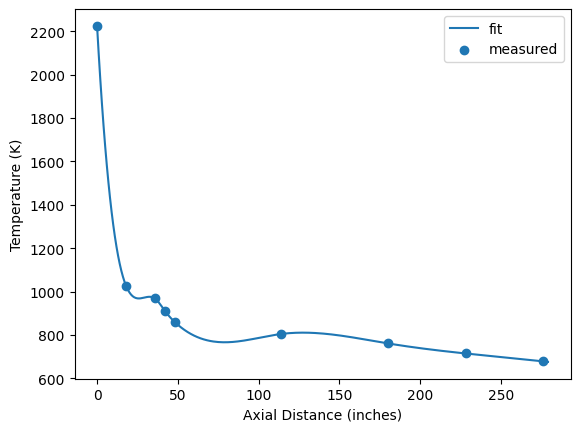

In [92]:
# Plot fit
# This code plots the measured axial temperature profile and the flame temperature estimate as a function of axial distance. The measured temperatures are plotted as circles and the flame temperature estimate is plotted as a line.

plt.plot(xf, T_fit, label="fit")
if 0 in measured_temps_locs_new:
    plt.scatter(measured_temps_locs_new, measured_temps_new, label="measured")
else:
    plt.scatter(0, T_peak, label="flame temperature estimate")
    plt.scatter(
        measured_temps_locs_new[1:],
        measured_temps_new[1:],
        label="measured temperatures",
    )
plt.ylabel("Temperature (K)")
plt.xlabel("Axial Distance (inches)")
plt.legend()
plt.savefig(
    output_folder + "\\temperature_fit_axial_distance.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

---
The following cell first makes a list of slices, with each slice being 1 inch long. The code makes a list of ones for the lengths of each slice, and uses a list of the diameters at each slice
to find the volume. The slice volumes are then added to a list. The flow of exhaust gas through each slice is corrected for temperature, since varying temperatures can change the properties
of the gas. The residence time is calculated by dividing the volume by the flow rate, $\left( L / \frac{L}{min} \right) = min$. 

In [93]:
# Convert axial length fit to residence time fit based on slice volumes, temperatures, and flow rates

# start by making list of slice volumes, slices have 1-inch lengths
v = [0]
for l, d in zip(lengths, diameters):
    slice_lengths = np.zeros(l) + 1  # a list of "1"s the length of the nth section
    slice_vols = (
        slice_lengths * np.pi * d**2 / 4
    )  # a list of the corresponding volumes
    v.extend(list(slice_vols))  # extend the total list of volumes

Q = (
    exhaust_gas_q * T_fit / 293.15
)  # list of Temp-corrected flows through each volume (L/min) based on ideal gas law
res_t = (
    60 * np.array(v) / (61 * Q)
)  # list of slice res times (seconds), divided by 61 to convert L/min to in^3/min
t_cum = np.cumsum(res_t)  # a list of slice cumulative res times (seconds)

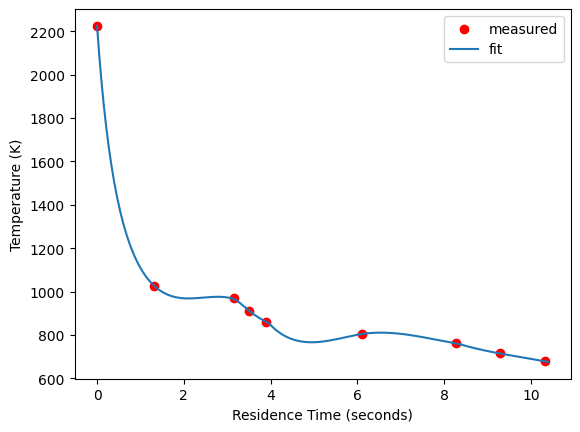

In [94]:
# Plot fit
if 0 in measured_temps_locs_new:
    plt.scatter(
        t_cum[np.round(measured_temps_locs_new, 0)],
        measured_temps_new,
        c="red",
        label="measured",
    )
else:
    plt.scatter(
        t_cum[np.round(measured_temps_locs_new[1:], 0)],
        measured_temps_new[1:],
        c="red",
        label="measured temperatures",
    )
    plt.scatter(
        t_cum[0], measured_temps_new[0], c="green", label="flame temperature estimate"
    )
plt.plot(t_cum, T_fit, label="fit")
plt.ylabel("Temperature (K)")
plt.xlabel("Residence Time (seconds)")
plt.legend()
plt.savefig(
    output_folder + "\\temperature_fit_res_time.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

In [95]:
# printing some info to screen and log file, prompt user to run PFR simulation
myprint("plots of temperature profile fit saved to output folder")
if run_with_dialog == True:
    time.sleep(2)
    myinput("if satisfied with fit, press enter to run PFR simulation")
else:
    ...
myprint("PFR simulation running...")

plots of temperature profile fit saved to output folder
PFR simulation running...


In [96]:
# Interpolate res time fit to user-defined resolution (not certain how this works)
i_t = t_cum[
    np.round(injection_loc, 0)
]  # round injection location to nearest integer, find corresponding res time to find when injection occurs

tinj = np.zeros(
    int(post_injection_duration / post_injection_res_time_step)
) + post_injection_res_time_step

tgap2 = np.zeros(int((t_cum[-1]-i_t-post_injection_duration)/elsewhere_res_time_step)) + elsewhere_res_time_step
tnew = np.concatenate(([0], tinj))
f = interpolate.interp1d(t_cum, T_fit)
Tnew = f(np.cumsum(tnew))  # vector of temperatures at each res time step

In [97]:
# define a function to map gri flame-gas species concentrations to mechanism species concentrations


def gri_to_mech(mech):
    gri_species = list(ct.Solution("files/gri3.0.yaml").species_names)
    mech_species = list(ct.Solution(mechanism).species_names)
    gri_c = list(ct.Solution(fname).X)
    mech_c = list(ct.Solution(mechanism).X)
    for species in gri_species:
        if species in mech_species:
            mech_c[mech_species.index(species)] = gri_c[gri_species.index(species)]
        else:
            ...
    return mech_c

In [98]:
# define the simulation loop for the res time vs. temp profile
tgap1 = np.zeros(int(i_t/elsewhere_res_time_step)) + elsewhere_res_time_step

def sim(
    t,
):  # We'll only use residence time now, as temperature will be calculated by Cantera
    intic = time.time()  # start timer

    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)

    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_index = ct.Solution(mechanism).species_index(injectant)

    nrp = []  # make list of net rates of progress
    flag = False  # flag to indicate when injection occurs
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1) + 2  # injection index

    c = []  # used to store concentrations
    # Start with some initial ambient temperature (or your initial condition)
    T_initial = 298.15  # Kelvin, this is just an example
    gas1.TPX = T_initial, pressure, concentrations
    T = [T_initial]
    """This has to be where the problem is.
    
    """
    
    for t_i in t:
        if timestep >= inj_i and flag == False:
            concentrations[injectant_index] = injectant_conc
            flag = True

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:  # append concentrations after injection
            c.append(concentrations)
            nrp.append(rates)

        r1 = ct.IdealGasConstPressureReactor(
            gas1, energy="on"
        )  # make reactor object with energy calculations enabled
        sim1 = ct.ReactorNet([r1])  # make reactor network
        sim1.atol = atol  # setting tolerances for integrator
        sim1.rtol = rtol
        sim1.advance(t_i)  # advance simulation by res time step

        T_current = gas1.T  # retrieve the temperature after the timestep
        T.append(T_current)  # store the current temperature

        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep += 1
        loop_t_cum += t_i
        if timestep % print_info_every == 0:  # report status every n time steps
            intoc = time.time()
            myprint(
                f"timestep: {timestep} total residence time (s): {str(round(loop_t_cum, 4))} temperature (K): {str(round(T_current, 2))} elapsed wall time(s): {str(round(intoc - intic, 2))}"
            )

    return c, nrp, T  # Now it also returns temperatures

In [99]:
# run the simulation
tic = time.time()
sim_out = sim(tnew)
sim_data = sim_out[0]
print(sim_out)
nrp = sim_out[1]
toc = time.time()
myprint(" ")
myprint(
    f"PFR simulation completed with wall time of: {str(round(toc - tic, 2))} seconds"
)

timestep: 100 total residence time (s): 0.099 temperature (K): 298.18 elapsed wall time(s): 8.09
 
PFR simulation completed with wall time of: 8.11 seconds


---
Almost everything below is for exporting or generating data, plots, figures

In [100]:
# generate excel files
myprint(" ")
if run_with_dialog == True:
    time.sleep(2)
    myinput("press enter to generate output")
else:
    ...
myprint("generating and saving output to output folder...")

cantera_species = ct.Solution(mechanism).species_names
tplot = np.concatenate(([0], np.cumsum(tinj), np.cumsum(tgap2) + sum(tinj)))[
    :-1
]  # list of time points for plotting
Tplot = Tnew[len(tnew) - len(sim_data) :]  # list of temperatures for plotting

sim_data_new = list(
    np.array(sim_data).T
)  # transpose list of concentrations, now each species is a list of concentrations at each time point
sim_data_new.insert(0, Tplot)  # insert list of temperatures at each time point
sim_data_new.insert(0, tplot)  # insert list of time points
sol = np.array(
    sim_data_new
).T  # make numpy array of concentrations, each row is a time point, each column is a species
columns = [
    "Residence Time (seconds)",
    "Temperature (K)",
] + cantera_species  # make list of column names for concentrations
pd.DataFrame(
    sol, columns=columns
).to_excel(  # make dataframe of concentrations, save to excel file
    output_folder + "\\solution_concentrations.xlsx"
)

eff_c = []  # make empty numpy array

for species in np.arange(len(cantera_species)):  # loop through each species
    name = cantera_species[species]  # get species name
    eff_c.append(
        [name, np.array(sim_data)[:, species][-1]]
    )  # append species name and final concentration to list
    print(
        "Species: "
        + name
        + " Final Concentration: "
        + str(np.array(sim_data)[:, species][-1])
    )

c = np.array(eff_c)  # make numpy array of final concentrations
c_sorted = c[
    (c[:, 1]).astype(float).argsort()[::-1]
]  # sort concentrations from largest to smallest
df = pd.DataFrame(  # make dataframe of final concentrations, save to excel file
    c_sorted, columns=["Species", "Effluent Concentration (mol fraction)"]
)
df.to_excel(output_folder + "\\solution_effluent_concentrations.xlsx")

 
generating and saving output to output folder...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
# make excel file of net rates of progress
cantera_reactions = list(
    ct.Solution(mechanism).reaction_equations()
)  # list of reaction equations
if save_rates_solution == False:
    ...
else:
    nrp_new = list(
        np.array(nrp).T
    )  # transpose list of net rates of progress, now each species is a list of net rates of progress at each time point
    nrp_new.insert(
        0, Tnew[len(tnew) - len(nrp) :]
    )  # insert list of temperatures at each time point
    nrp_new.insert(0, tplot)  # insert list of time points
    sol = np.array(
        nrp_new
    ).T  # make numpy array of net rates of progress, each row is a time point, each column is a species
    columns = [
        "Residence Time (seconds)",
        "Temperature (K)",
    ] + cantera_reactions  # make list of column names for net rates of progress
    pd.DataFrame(
        sol, columns=columns
    ).to_excel(  # make dataframe of net rates of progress, save to excel file
        output_folder + "\\solution_reactions.xlsx"
    )

In [ ]:
# make plots of concentrations vs. res time
data = np.array(
    sim_data
).T  # transpose sim data, now each species is a list of concentrations at each time point
fig = go.Figure()  # make figure
for i in np.arange(len(cantera_species)):
    if (
        max(data[i]) < concentrations_interactive_plot_cutoff
    ):  # if max concentration is less than cutoff, don't plot
        ...
    else:
        fig.add_trace(
            go.Scatter(x=tplot, y=data[i], name=cantera_species[i])
        )  # plot concentration vs. time
fig.update_yaxes(
    title_text="Concentration (mol fraction)", type="log", exponentformat="power"
)
fig.update_xaxes(title_text="Residence Time (seconds)")
fig.update_layout(template="plotly_white")
fig.write_html(output_folder + "\\interactive_plot_concentrations.html")

In [ ]:
# make individual plots of concentrations
data = np.array(
    nrp
).T  # transpose net rates of progress, now each species is a list of net rates of progress at each time point
fig = go.Figure()
for i in np.arange(len(cantera_reactions)):  # loop through each reaction
    if (
        max(data[i]) < rates_interactive_plot_cutoff
    ):  # if max net rate of progress is less than cutoff, don't plot
        ...
    else:
        fig.add_trace(
            go.Scatter(x=tplot, y=data[i], name=cantera_reactions[i])
        )  # plot net rate of progress vs. time

ylabel = "Net Rate of Progress (kmol/m3/s)"
fig.update_yaxes(title_text=ylabel, type="log", exponentformat="power")
fig.update_xaxes(title_text="Residence Time (seconds)")
fig.update_layout(template="plotly_white")
fig.write_html(
    output_folder + "\\interactive_plot_net_rates.html", include_plotlyjs="cdn"
)

In [ ]:
# generate figures and excel files
# organize them based on maximum concentration across all slices

if individual_plots == True:
    if os.path.exists(output_folder + r"\\individual_major_species") == False:
        os.makedirs(output_folder + r"\\individual_major_species")
    if os.path.exists(output_folder + r"\\individual_minor_species") == False:
        os.makedirs(output_folder + r"\\individual_minor_species")
    neg_species = []  # negligible species
    eff_c = []  # effluent concentrations

    for species in np.arange(len(cantera_species)):
        name = cantera_species[species]
        eff_c.append([name, np.array(sim_data)[:, species][-1]])

        plt.plot(tplot, np.array(sim_data)[:, species])
        plt.xlabel("Residence time (seconds)")
        plt.ylabel("Concentration (mol fraction)")
        plt.title(name, fontsize=20, fontweight="bold")
        plt.yscale("log")
        if np.max(np.array(sim_data)[:, species]) > major_species_cutoff:
            plt.savefig(
                output_folder + "\\individual_major_species\\" + name + ".png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white",
            )
        elif np.max(np.array(sim_data)[:, species]) > minor_species_cutoff:
            plt.savefig(
                output_folder + "\\individual_minor_species\\" + name + ".png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white",
            )
        else:
            neg_species.append([name, np.max(np.array(sim_data)[:, species])])
        plt.close()

    df = pd.DataFrame(
        neg_species, columns=["Species", "Maximum Concentration (mol fraction)"]
    )
    df.to_excel(output_folder + "\\negligible_species.xlsx")

else:
    ...

In [ ]:
# generate path diagram
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)
retry = "y"

while retry == "y":
    plot_step = np.abs(
        tplot - path_res_time
    ).argmin()  # find index of res time closest to user input
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, path_element)
    diagram.threshold = path_threshold
    diagram.dot_options = 'node[shape="box"]'
    title = (
        (
            f"Path diagram for {path_element} at residence time of {str(path_res_time)}"
            + " seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r"
        )
        + " with displayed threshold of "
    ) + str(path_threshold)
    diagram.title = title
    diagram.show_details = path_details
    diagram.display_only(  # display only species connected to path element
        -1 if path_species == "all" else gas.species_index(path_species)
    )
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f"dot {dot_file} -Tpng -o {png_file} -Gdpi=100")
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    if run_with_dialog == True:
        retry = myinput(
            "path diagram saved to output folder...generate new path diagram? (y/n): "
        )
    else:
        retry = "n"
    if retry == "y":
        path_res_time = float(
            myinput("type path diagram residence time (in seconds) and press enter: ")
        )
        path_element = myinput("type path diagram element symbol and press enter: ")
        path_species = myinput(
            "type path diagram species  and press enter (all/individual species name): "
        )
        path_threshold = float(myinput("type path diagram threshold and press enter: "))
    path_details = (
        input("show path details? (y/n) and press enter: ").lower().strip() == "y"
    )

In [ ]:
# stop timer and print total wall time
tot_toc = time.time()
myprint(
    f"PFR run completed with total wall time of: {str(round(tot_toc - tot_tic, 2))} seconds"
)
time.sleep(3)

---

In [ ]:
# make path diagram interactive
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)

t_min = 0.0
t_max = post_injection_duration  # max(tplot)
t_step = post_injection_res_time_step  # elsewhere_res_time_step

thresh_min = 0.0
thresh_max = 1.0
thresh_step = 1e-2


def format_float(num):
    return np.format_float_positional(num, trim="-")


@interact(
    res_time=SelectionSlider(
        value=t_min + t_step,
        options=[("%g" % i, i) for i in np.arange(t_min, t_max, t_step)],
    ),
    threshold=SelectionSlider(
        value=thresh_min + thresh_step,
        options=[("%g" % i, i) for i in np.arange(thresh_min, thresh_max, thresh_step)],
    ),
    details=widgets.ToggleButton(),
    species=widgets.Dropdown(
        options=gas.element_names,
        value="F",
        description="Element",
        disabled=False,
    ),
)
def plot_reaction_path_diagrams(res_time, threshold, details, species):
    plot_step = np.abs(tplot - res_time).argmin()
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    P = ct.one_atm
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, species)
    diagram.threshold = threshold
    diagram.dot_options = 'node[shape="box"]'
    diagram.show_details = details
    diagram.display_only(
        -1 if path_species == "all" else gas.species_index(path_species)
    )
    title = (
        f"Path diagram for {species} at residence time of {str(res_time)}"
        + " seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r"
        + " with displayed threshold of "
        + str(threshold)
    )
    diagram.title = title
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f"dot {dot_file} -Tpng -o {png_file} -Gdpi=300")
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis("off")
    plt.show()